In [121]:
from foobah.gcode import GCODE
from foobah.utils import preview_svg, preview_png
from foobah.methods import line_threshold
from foobah import constants
from foobah.constants import XMAX, XMIN, YMAX, YMIN

import PIL
import PIL.Image
import PIL.ImageFilter

import numpy as np

from random import uniform

from IPython.display import display

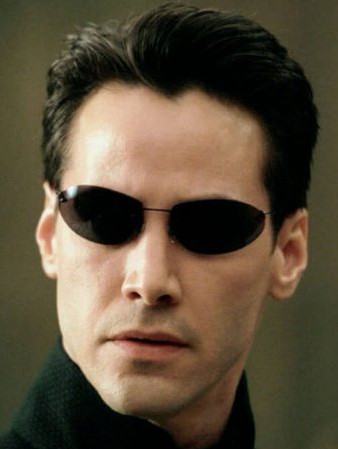

In [122]:
basename = "neo"

scale = 1
# image_name = "images/moonface.png"
# image_name = "images/einstein.jpg"
# image_name = "images/david-bowie.jpg"
# image_name  = "images/scary_penguin.webp"
# image_name = "images/portrait_1.jpg"
# image_name = "images/simplex_noise_difference_clouds.png"
# image_name = "images/dafoe.jpg"
image_name = "images/neo.jpg"

image = PIL.Image.open(image_name)

image = image.resize((int(image.width / scale), int(image.height / scale)), PIL.Image.ANTIALIAS)
# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE)
# image = image.filter(PIL.ImageFilter.SMOOTH_MORE)
# image = image.filter(PIL.ImageFilter.CONTOUR)
# image = image.filter(PIL.ImageFilter.DETAIL)
# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE)
# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE)
# image = image.filter(PIL.ImageFilter.SMOOTH_MORE)

# image = image.rotate(-90, expand=True)

image = image.convert("RGB")

width = image.width
height = image.height

display(image)

In [123]:
def move_to(gcode, x, y):
    gcode.move_to(
        ((x) / image.width) * (XMAX - XMIN) + XMIN,
        ((y) / image.height) * (YMAX - YMIN) + YMIN,
    )

In [124]:
gcode = GCODE(basename, feedrate=1500)
# gcode.move_to_starting_position()
gcode.pen_down()
gcode.draw_boundaries()
gcode.pen_up()

gcode.pen_up()
gcode.move_to_mid_point()

In [125]:
from math import sqrt, pow

gamma_ish = 1.5
intensity_threshold = 0.01
pixel_size = 3
min_dy = 0.5
max_dy = pixel_size

writing = False

intensities = []

for x_center in range(0 +  pixel_size // 2, image.width +  pixel_size // 2, pixel_size):
    y_center =  0 + pixel_size / 2.0
    y = y_center - pixel_size # This forces the pixel intensity to be evaluated in the first step
    y = 0
    dy = -1
    
    move_to(gcode, x_center, y)
    gcode.pen_down()
    writing = True
    
    counter = 0
    
    while y < image.height:
        if y - y_center >= pixel_size or dy < 0:
            y_center += pixel_size

            intensity_ = 0
            sample_count = 0
            for x_ in range(0, pixel_size):
                if x_center + x_ >= image.width or  y_center >= image.height:
                    continue

                if y_center + y_ >= image.height:
                    continue

                r, g, b = image.getpixel((x_center + x_, y_center + y_))
                intensity_ += ((255 - r) + (255 - g) + (255 - b)) / (255 * 3.0)
                sample_count += 1
                
            if sample_count == 0:
                counter += 1
                y += dy
                continue

            intensity_ /= sample_count
            intensities.append(intensity_)
            
            if len(intensities) > pixel_size / 2:
                intensities.pop(0)
            
            intensity = sum(intensities) / len(intensities)
                    
            pixel_intensity = max_dy - ((pow(intensity, 1 / gamma_ish) * 1) * max_dy)
            dy = pixel_intensity
            dy = max(dy, min_dy)
            dy = min(dy, max_dy)
        
        if intensity < intensity_threshold and writing:
            gcode.pen_up()
            writing = False
        
        if intensity >= intensity_threshold and not writing:
            gcode.pen_down()
            writing = True
        
        if counter % 2 == 0:
            x = x_center + (pixel_size / 2.1) * intensity
        else:
            x = x_center - (pixel_size / 2.1) * intensity
        
        counter += 1
        y += dy
        
        move_to(gcode, x, y)
        
    gcode.pen_up()
    writing = False

In [126]:
gcode.pen_up()
# gcode.move_to_starting_position()
gcode.flush()

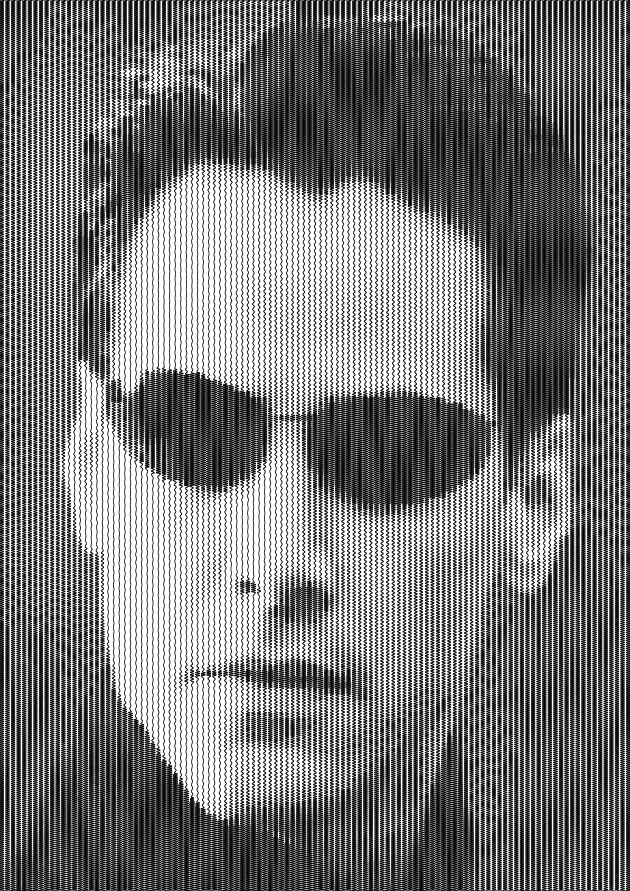

In [127]:
preview_png(basename, scale=3)